# An example from slides

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import numpy.random as npr
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow.contrib.eager as tfe

keras = tf.keras
tf.enable_eager_execution()

In [3]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

In [4]:
from neural_ode import NeuralODE

## Initial conditions

In [5]:
t = np.linspace(0, 25, 200)
h0 = tf.to_float([[1., 0.]])
W = tf.to_float([[-0.1, 1.0], [-0.2, -0.1]])

In [6]:
W

<tf.Tensor: id=2, shape=(2, 2), dtype=float32, numpy=
array([[-0.1,  1. ],
       [-0.2, -0.1]], dtype=float32)>

In [7]:
class Lambda(tf.keras.Model):
    def call(self, inputs, **kwargs):
        t, h = inputs
        return tf.matmul(h, W)

Integrate dynamics to obtain trajectory over time

In [8]:
neural_ode = NeuralODE(Lambda(), t=t)
hN, states_history = neural_ode.forward(h0, return_states="numpy")
initial_path = np.concatenate(states_history)

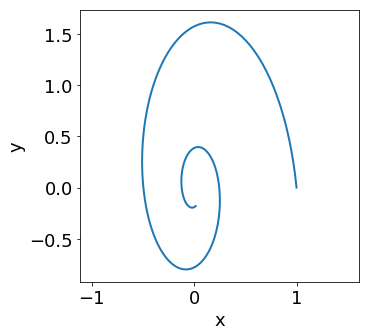

In [12]:
def plot_trajectory(trajectories, fig=True):
    if fig:
        plt.figure(figsize=(5, 5))
        
    for path in trajectories:
        if type(path) == tuple:
            c, label, path = path
            plt.plot(*path.T, c, lw=2, label=label)
        else:
            plt.plot(*path.T, lw=2)
    plt.axis("equal")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    

plot_trajectory([initial_path])

In [13]:
optimizer = tf.train.MomentumOptimizer(learning_rate=1e-2, momentum=0.95)

In [17]:
def compute_gradients_and_update():    
    with tf.GradientTape() as g:       
        hN = neural_ode.forward(h0_var)
        g.watch(hN)
        loss = tf.reduce_sum((hN_target - hN)**2)
        
    dLoss = g.gradient(loss, hN) # same what 2 * (hN_target - hN)
    h0_reconstruction, dfdh0, dWeights = neural_ode.backward(hN, dLoss)
    optimizer.apply_gradients([(dfdh0, h0_var)])
    return loss

# Compile EAGER graph to static (this will be much faster)
compute_gradients_and_update = tfe.defun(compute_gradients_and_update)

In [18]:
h0_var = tf.Variable(h0)
hN_target = tf.to_float([[0., 0.5]])

  0%|          | 0/201 [00:00<?, ?it/s]

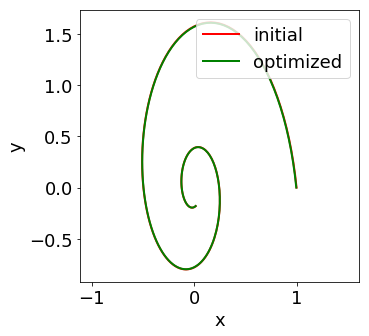

 22%|██▏       | 44/201 [00:36<02:09,  1.22it/s]

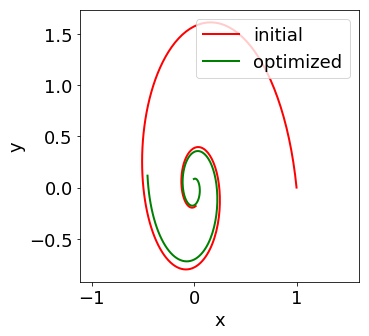

 48%|████▊     | 96/201 [00:37<00:40,  2.57it/s]

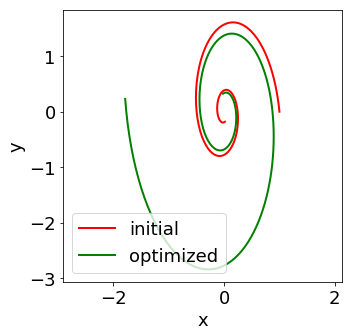

 72%|███████▏  | 145/201 [00:38<00:14,  3.78it/s]

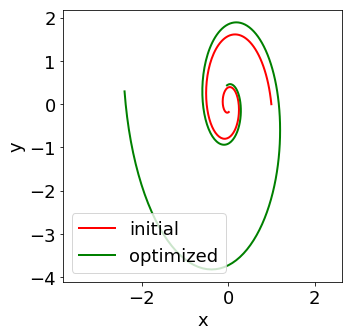

 97%|█████████▋| 194/201 [00:39<00:01,  4.92it/s]

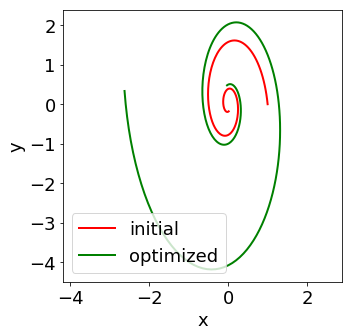

100%|██████████| 201/201 [00:39<00:00,  5.03it/s]


In [19]:
loss_history = []
for step in tqdm(range(201)):    
    loss = compute_gradients_and_update()
    loss_history.append(loss.numpy())
    
    if step % 50 == 0:        
        yN, states_history_model = neural_ode.forward(h0_var, return_states="numpy")    
        plot_trajectory([
            ("r", "initial", initial_path), 
            ("g", "optimized", np.concatenate(states_history_model))])        
        plt.show()